In [1]:
target_version='0.19.0'

In [2]:
try:
    import proplot as pplt
except:
    !pip install git+https://github.com/jbusecke/cmip6_preprocessing.git --upgrade
    !pip install xarray=={target_version} --upgrade #--upgrade
    !pip install proplot

  Cloning https://github.com/jbusecke/cmip6_preprocessing.git to /tmp/pip-req-build-27hh9inq
  Running command git clone -q https://github.com/jbusecke/cmip6_preprocessing.git /tmp/pip-req-build-27hh9inq
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached pint_xarray-0.3-py3-none-any.whl (32 kB)
  Created wheel for xmip: filename=xmip-0.6.1rc1.dev6+gf5e778c-py3-none-any.whl size=54386 sha256=f9c291b520bcbfdd510de868348ce2b7183c88b6221f0bee1b3d0455a8820e87
  Stored in directory: /tmp/pip-ephem-wheel-cache-86f_c0oa/wheels/09/54/8a/ad2f90d350fd12393b2d537c42abcbdd2c7820c21b80b07317
Successfully built xmip
  Using cached xarray-0.19.0-py3-none-any.whl (827 kB)
  Using cached proplot-0.9.5-py3-none-any.whl (8.0 MB)


In [3]:
from dask_gateway import Gateway
gateway = Gateway()
from dask.distributed import Client

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [4]:
'''properly shutdown any previous clusters'''
clusters=gateway.list_clusters()
if clusters != []:
    print(f'found {len(clusters)} clusters')
    for cluster in clusters:
        cluster = gateway.connect(cluster.name)
        client=Client(cluster)
        client.close()
        cluster.shutdown()

In [5]:
'''call new cluster'''        
cluster = gateway.new_cluster(worker_memory=2)
cluster.scale(4)
client = Client(cluster)
cluster.name

'pangeo.dad482a6daca4530ad73377c1fba6032'

In [ ]:
client

Connection method: Cluster object,Cluster type: GatewayCluster
Dashboard: /services/dask-gateway/clusters/pangeo.dad482a6daca4530ad73377c1fba6032/status,


In [8]:
import numpy as np
import pandas as pd
from glob import glob

In [9]:
import proplot as pplt

In [10]:
import cmip6_preprocessing.preprocessing as cpp
import cmip6_preprocessing.grids as cpp_gr
import cmip6_preprocessing.postprocessing as cpp_pp

In [11]:
import intake 

In [17]:
from cmip6_preprocessing.utils import google_cmip_col
col=google_cmip_col()
# col = intake.open_esm_datastore("https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json")
# col = intake.open_esm_datastore("https://cmip6-nc.s3.us-east-2.amazonaws.com/esgf-world.json")

In [18]:
query = dict(
    table_id=['Amon','Omon','Ofx'],\
    grid_label=['gn'],\
)

In [19]:
variables=['tos','thetao','so','hfds','wfo','uo','vo','umo','vmo',
           'tauuo','tauvo','psl','msftbarot','uas','vas','thkcello']
experiments=['historical','ssp126','ssp585']

In [20]:
def df_firstens(col_subset):
    full_df=col_subset.df
    grouped = full_df.groupby(["variable_id"])
    gr=grouped.get_group(variables[0])
    newdf=gr.groupby('source_id').first().reset_index()
    models=list(newdf['source_id'].values)
    var_list=[]
    for variable in variables[1:]:
        for row in newdf.iterrows():
            model=row[1]['source_id']
            ens=row[1]['member_id']
            row_var=full_df.loc[(full_df['source_id'] == model) & \
                               (full_df['member_id'] ==ens) & \
                               (full_df['variable_id'] == variable)]
            var_list.append(row_var)
    vars_df=pd.concat(var_list,axis=0,ignore_index=True)
    newdf=newdf.append(vars_df,ignore_index=True)
    return newdf

In [21]:
df_exp={}
for exp in experiments:
    print(exp)
    col_exp=col.search(**query,experiment_id=exp)
    df_exp[exp]=df_firstens(col_exp)
#     gr[exp]=df[exp].groupby(['source_id'])
#     models[exp]=list(g1.indices.keys())

historical
ssp126
ssp585


In [22]:
variables=list(df_exp['ssp126']['variable_id'].unique())

In [23]:
df_all=pd.concat(df_exp.values())

In [24]:
all_models=sorted(df_all['source_id'].unique())

In [25]:
len(all_models)

54

In [26]:
df_all.head()

,source_id,activity_id,institution_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,ACCESS-CM2,CMIP,CSIRO-ARCCSS,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/...,NaN,20191108
1,ACCESS-ESM1-5,CMIP,CSIRO,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/hist...,NaN,20191115
2,AWI-CM-1-1-MR,CMIP,AWI,historical,r2i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/AWI/AWI-CM-1-1-MR/histor...,NaN,20181218
3,AWI-ESM-1-1-LR,CMIP,AWI,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/AWI/AWI-ESM-1-1-LR/histo...,NaN,20200212
4,BCC-CSM2-MR,CMIP,BCC,historical,r2i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/historic...,NaN,20181031


In [27]:
# variables=['thetao','so','mld','msf','stratification_mlbase','windstress','seaice','psl','hfds','wfo']
# NAMES=['SST','SSS','MLD','B_STRM','STRAT_BASE_ML','WINDSTRESS','SIC','SLP','HEATFLUX','SALTFLUX']

In [28]:
dfall_sub=df_all[['source_id','experiment_id','variable_id']]

In [29]:
dfall_sub.head()

,source_id,experiment_id,variable_id
0,ACCESS-CM2,historical,tos
1,ACCESS-ESM1-5,historical,tos
2,AWI-CM-1-1-MR,historical,tos
3,AWI-ESM-1-1-LR,historical,tos
4,BCC-CSM2-MR,historical,tos


In [30]:
gr_var=dfall_sub.groupby('variable_id')
var_dict={}
for var,df in gr_var:
    var_dict[var]=df

In [31]:
varvalues_dict={}
for var in sorted(var_dict.keys()):
    print(var)
    df=var_dict[var]
    gr_exp=df.groupby('experiment_id')
    j=0
    values=[]
    for exp in experiments:
        print(exp)
        try:
            df2=gr_exp.get_group(exp)
            models=list(df2['source_id'])
            nlist=[j if name in models else np.nan for name in all_models]
            values.append(nlist)
        except Exception as err:
            print(err)
            nlist=[np.nan for name in all_models]
            values.append(nlist)
        j=j+1      
    varvalues_dict[var]=np.asarray(values)


hfds
historical
ssp126
ssp585
msftbarot
historical
ssp126
ssp585
psl
historical
ssp126
ssp585
so
historical
ssp126
ssp585
tauuo
historical
ssp126
ssp585
tauvo
historical
ssp126
ssp585
thetao
historical
ssp126
ssp585
thkcello
historical
ssp126
ssp585
tos
historical
ssp126
ssp585
uas
historical
ssp126
ssp585
umo
historical
ssp126
ssp585
uo
historical
ssp126
ssp585
vas
historical
ssp126
ssp585
vmo
historical
ssp126
ssp585
vo
historical
ssp126
ssp585
wfo
historical
ssp126
ssp585


In [32]:
for i,var in enumerate(variables):
    if i==0:
        hmapdata=varvalues_dict[var]
    else:
        hmapdata=np.vstack((hmapdata,varvalues_dict[var]))

In [33]:
colname=[[name]*3 for name in variables]
df_colname=[x for col in colname for x in col]

In [34]:
hmap_df=pd.DataFrame(hmapdata, index=df_colname, columns=all_models)
# hmap_df=hmap_df.transpose()

In [35]:
yticks=[1]+list(range(4,50,3))

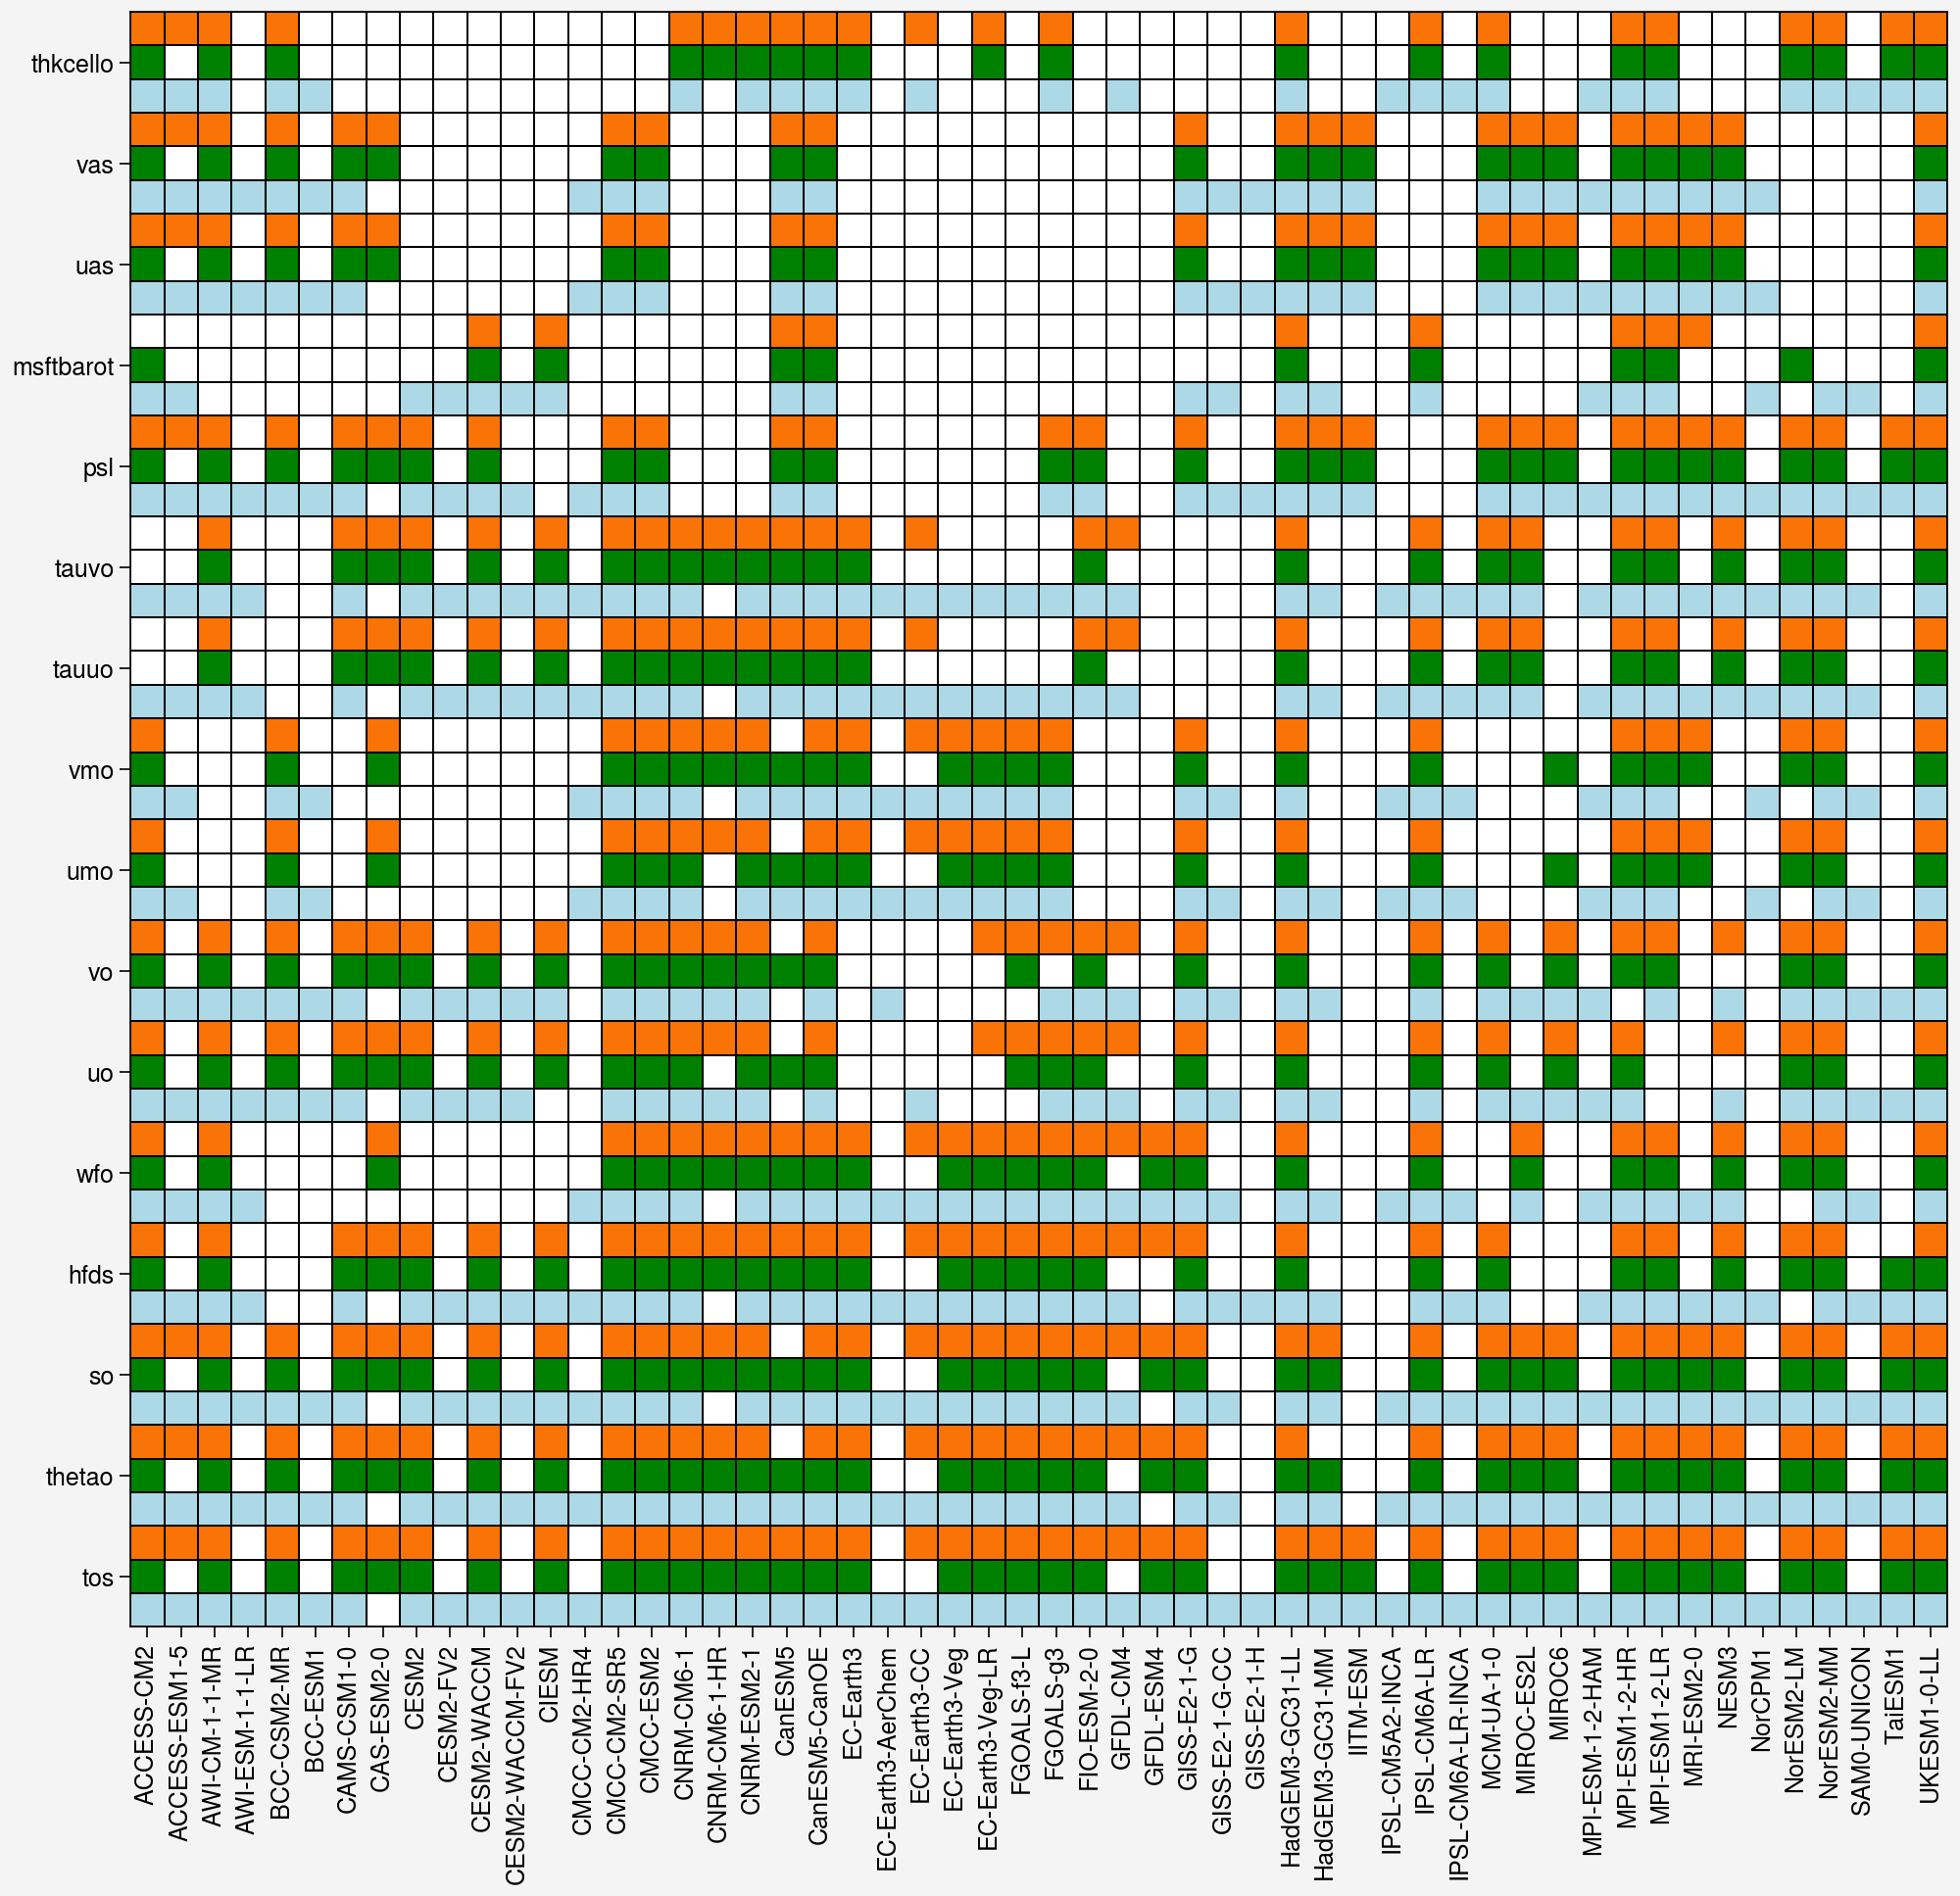

In [36]:
fig=pplt.figure(figwidth=10)
ax=fig.subplot(111)
hmap1=ax.heatmap(hmap_df,c=['lightblue','green','orange'],ec='k',values=[0,1,2])
ax.format(xrotation=90,ylocator=yticks)
fig.save('data_process_map.png',dpi=600)

In [37]:
selvariables=['thetao','so','hfds','uo','vo','umo','vmo','psl','uas','vas','thkcello']

In [38]:
for i,var in enumerate(selvariables):
    if i==0:
        hmapdata=varvalues_dict[var]
    else:
        hmapdata=np.vstack((hmapdata,varvalues_dict[var]))

In [39]:
colname=[[name]*3 for name in selvariables]
df_colname=[x for col in colname for x in col]

In [40]:
hmap_df=pd.DataFrame(hmapdata, index=df_colname, columns=all_models)

In [41]:
hmap_df=hmap_df.transpose()

In [42]:
xticks=[1]+list(range(4,41,3))

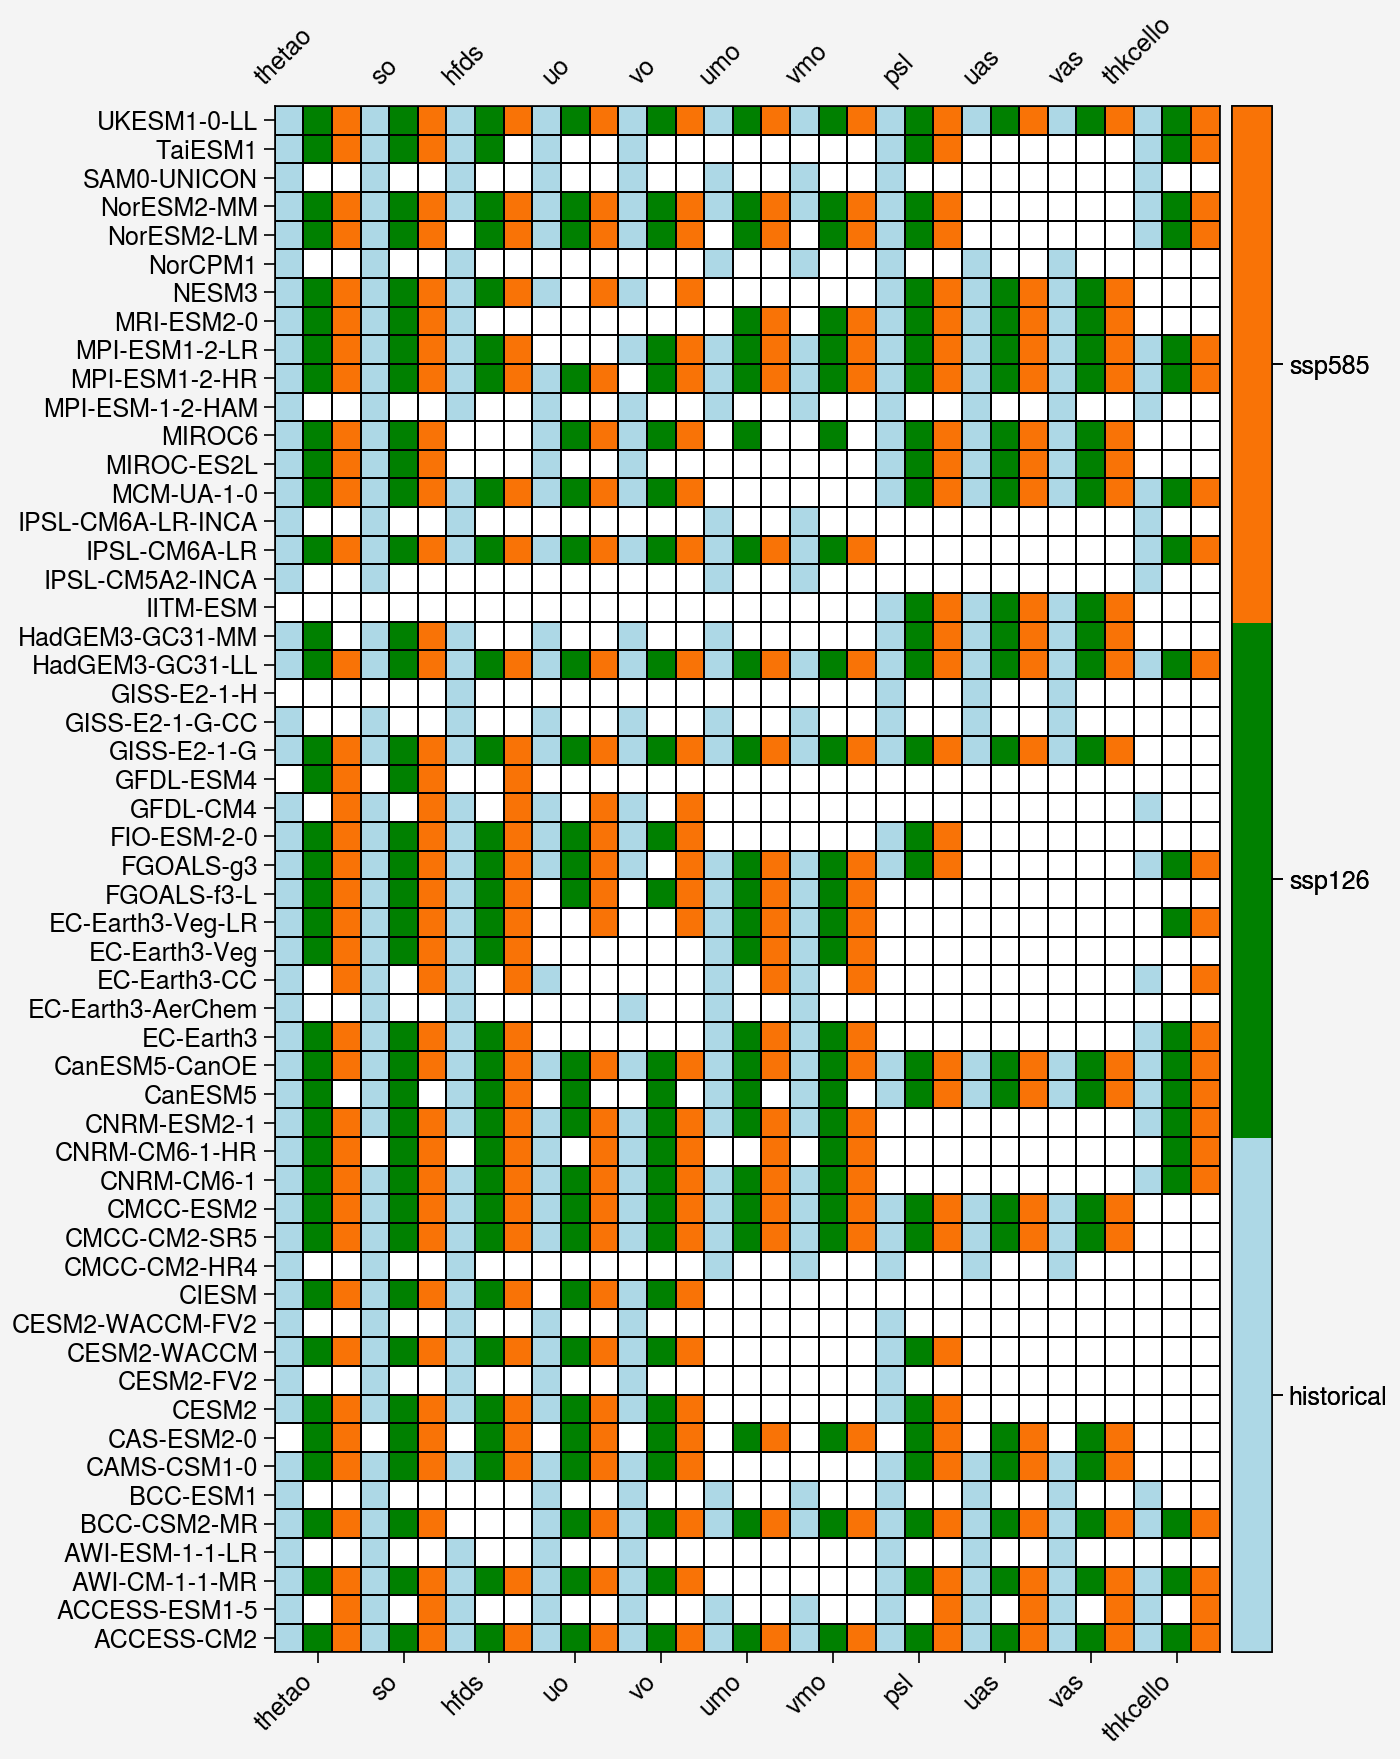

In [43]:
fig=pplt.figure(figwidth=7)
ax=fig.subplot(111)
hmap1=ax.heatmap(hmap_df,c=['lightblue','green','orange'],ec='k',values=[0,1,2])
ax.format(xrotation=45,xlocator=xticks,xticklabelloc='both')
ax.colorbar(hmap1,loc='r',ticklabels=experiments)
# fig.save('datavailaibility.png',dpi=600)

In [45]:
hmap_df_test=hmap_df.notnull()

In [46]:
hmap_df_test.sum(axis=1)

ACCESS-CM2           33
ACCESS-ESM1-5        17
AWI-CM-1-1-MR        27
AWI-ESM-1-1-LR        8
BCC-CSM2-MR          30
BCC-ESM1             10
CAMS-CSM1-0          24
CAS-ESM2-0           20
CESM2                18
CESM2-FV2             6
CESM2-WACCM          18
CESM2-WACCM-FV2       6
CIESM                14
CMCC-CM2-HR4          8
CMCC-CM2-SR5         30
CMCC-ESM2            30
CNRM-CM6-1           24
CNRM-CM6-1-HR        17
CNRM-ESM2-1          24
CanESM5              25
CanESM5-CanOE        33
EC-Earth3            18
EC-Earth3-AerChem     6
EC-Earth3-CC         13
EC-Earth3-Veg        15
EC-Earth3-Veg-LR     19
FGOALS-f3-L          19
FGOALS-g3            26
FIO-ESM-2-0          18
GFDL-CM4             11
GFDL-ESM4             5
GISS-E2-1-G          30
GISS-E2-1-G-CC       10
GISS-E2-1-H           4
HadGEM3-GC31-LL      33
HadGEM3-GC31-MM      18
IITM-ESM              9
IPSL-CM5A2-INCA       5
IPSL-CM6A-LR         24
IPSL-CM6A-LR-INCA     6
MCM-UA-1-0           27
MIROC-ES2L      